<h3> Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances, silhouette_score, pairwise_distances, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

import skfuzzy as fuzz
from skfuzzy import cmeans
from sklearn.base import BaseEstimator, ClusterMixin

from kneed import KneeLocator
# from collections import defaultdict
# import difflib

In [2]:
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

<h3> EDA

In [ ]:
print("data:")
display(data.head(2))

print()
print("data_by_genres:")
display(genre_data.head(2))

print()
print("data_by_year:")
display(year_data.head(2))

print()
print("data_by_artist:")
display(artist_data.head(2))

In [ ]:
print("data info: ")

print(f"Any Null Data Found: {data.isnull().any().any()}")
print()

print(data.dtypes)
data.describe()

In [ ]:
print("Genre Data Info: ")

print(f"Any Null Data Found: {genre_data.isnull().any().any()}")
print()

print(genre_data.dtypes)
genre_data.describe()

In [ ]:
print("Year Data Info: ")

print(f"Any Null Data Found: {year_data.isnull().any().any()}")
print()

print(year_data.dtypes)
year_data.describe()

In [ ]:
print("Artist Data Info: ")

print(f"Any Null Data Found: {artist_data.isnull().any().any()}")
print()

print(artist_data.dtypes)
artist_data.describe()

In [ ]:
#create decades column feature engineering
data["decade"] = data["year"].apply(lambda year : f"{(year//10)*10}s")

#graph it
sns.countplot(x= data['decade'])

#labels and title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Count of songs released in each Decade')

#rotate x vertically
plt.xticks(rotation=60)

# Show the plot
plt.show()

In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'valence']
fig = px.line(year_data, x = 'year', y = sound_features, title='Trend of various sound features over decades')
fig.show()

In [ ]:
fig = px.line(year_data, x='year', y='loudness',title='Trend of loudness over decades')
fig.show()

In [ ]:
#get data for these genres
rock_data = genre_data[genre_data["genres"] == "rock"]
rap_data = genre_data[genre_data["genres"] == "rap"]
classical_data = genre_data[genre_data["genres"] == "classical"]
indie_rock_data = genre_data[genre_data["genres"] == "indie rock"]
metal_data = genre_data[genre_data["genres"] == "metal"]
country_data = genre_data[genre_data["genres"] == "country"]
electro_data = genre_data[genre_data["genres"] == "electro"]
pop_data = genre_data[genre_data["genres"] == "pop"]
jazz_data = genre_data[genre_data["genres"] == "jazz"]
techno_data = genre_data[genre_data["genres"] == "techno"]

#combine them
combined_genres = pd.concat([rock_data, rap_data, classical_data, indie_rock_data, metal_data, 
                             country_data, electro_data, pop_data, jazz_data, techno_data])

#graph it
fig = px.bar(combined_genres, x='genres', y=sound_features, barmode='group',
            title='Trend of various sound features over 10 most well known genres')
fig.show()

In [ ]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=sound_features, barmode='group',
            title='Trend of various sound features over top 10 genres')
fig.show()

In [ ]:
top10_popular_artists = artist_data.nlargest(10, 'popularity')
top10_most_song_produced_artists = artist_data.nlargest(10, 'count')

print('Top 10 Artists that produced most songs:')
top10_most_song_produced_artists[['count','artists']].sort_values('count',ascending=False)

<h3> Clustering methods

In [ ]:
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

<h4> All Pipelines

<h4> Part 1: Genre Data <br>
    Standardization

In [3]:
genre_data.head()

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   
2     1                   8-bit      0.762000      0.712000  1.151770e+05   
3     1                      []      0.651417      0.529093  2.328809e+05   
4     1              a cappella      0.676557      0.538961  1.906285e+05   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1  0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2  0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3  0.419146          0.205309  0.218696 -12.288965     0.107872  112.857352   
4  0.316434          0.003003  0.172254 -12.479387     0.082851  112.110362   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5  
2  0.975000   48.000000    7  
3  0.513604   20.859882    7  
4  0.448249   45.820071    7

In [4]:
#first pipeline sued to calculate Inertia and Silhuette Score
start_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(init='k-means++'))
])

#standardize genre data
X = genre_data.select_dtypes(np.number)
start_cluster_pipeline.fit(X)

#view standardized data
scaled_genre_data = start_cluster_pipeline.named_steps['scaler'].transform(X)
scaled_genre_data = pd.DataFrame(scaled_genre_data, columns=["mode", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "key"])
scaled_genre_data.head()

mode  acousticness  danceability  duration_ms    energy  \
0  0.447484      1.808197     -2.484719    -0.966000 -2.089283   
1  0.447484      0.292578     -1.578931     8.423062 -0.471170   
2  0.447484      1.128407      1.160449    -1.442757  1.095589   
3  0.447484      0.782518     -0.053735    -0.199068 -0.605666   
4  0.447484      0.861153      0.011776    -0.645517 -1.043772   

   instrumentalness  liveness  loudness  speechiness     tempo   valence  \
0          1.479575  1.828029 -3.912689    -0.534628 -2.500950 -1.927609   
1          0.996674 -0.669260 -1.181781    -0.084146  0.072537 -1.342996   
2          2.486616 -0.723408  0.247722    -0.454680  0.825894  2.389920   
3         -0.022662  0.280445 -0.331412     0.301775 -0.352759  0.103360   
4         -0.779555 -0.222497 -0.366883    -0.009152 -0.395526 -0.220526   

   popularity       key  
0   -0.721720  0.018179  
1    0.751277 -0.278774  
2    0.482555  0.315131  
3   -1.138147  0.315131  
4    0.352378  0.315131

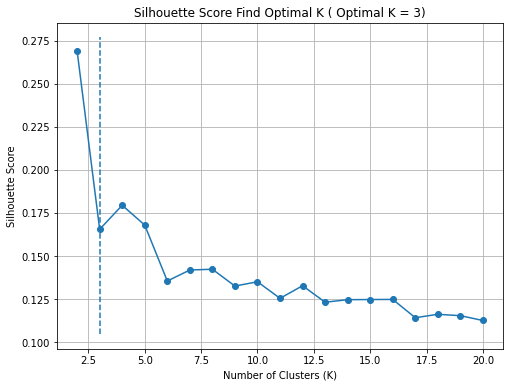

In [5]:
#silhouette_scores for best K value
k_values = range(2, 21)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(scaled_genre_data)
    score = silhouette_score(scaled_genre_data, kmeans.labels_)
    silhouette_scores.append(score)

kneedle = KneeLocator(k_values, silhouette_scores, curve='convex', direction='decreasing')
silhouette_knee_point = kneedle.knee

# Plot Silhouette Scores for different values of K and pinpoint Optimal K
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker="o")
plt.title(f"Silhouette Score Find Optimal K ( Optimal K = {silhouette_knee_point})")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)

# The elbow point 
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.show()

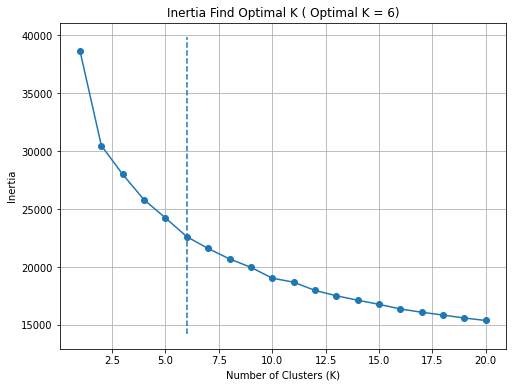

In [6]:
# Inertia for best K value
k_values = range(1, 21)
inertia_score = []

for k in k_values:
    cluster_labels = KMeans(n_clusters=k, init='k-means++')
    cluster_labels.fit(scaled_genre_data)
    inertia = cluster_labels.inertia_
    inertia_score.append(inertia)

kneedle = KneeLocator(k_values, inertia_score, curve='convex', direction='decreasing')
inertia_knee_point = kneedle.knee

# Plot Inertia for different values of K and pinpoint Optimal K
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_score, "-o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title(f"Inertia Find Optimal K ( Optimal K = {inertia_knee_point})")
plt.grid(True)

# The elbow point 
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [ ]:
"""
silhouette score k = 4
Inertia k = 6

Inertia doesnt have a clear elbow:
    meaning that the data doesnt have a clear cluster-like structure

Silhouette Score doesnt show a clear peak:
    meaning that there is no obvious numbers of clusters that is best
    
In cases where clusters are not well-separated, the silhouette score might be low 
because points will not be much closer to their own cluster center than to others, 
even if the inertia is steadily decreasing
"""

<h4> K-Means on Genres

In [52]:
#kmeans pipeline used after calculating Inertia and Silhuette Score
kmeans_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(n_clusters= inertia_knee_point, init='k-means++'))
])

X = genre_data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)
# centroids = kmeans_cluster_pipeline.named_steps['kmeans'].cluster_centers_

genre_data['cluster'] = kmeans_cluster_pipeline.predict(X)
genre_data.head(2)

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834    0.3616 -31.514333     0.040567   75.336500   
1  0.450678          0.477762    0.1310 -16.854000     0.076817  120.285667   

    valence  popularity  key  cluster  
0  0.103783   27.833333    6        1  
1  0.221750   52.500000    5        1

In [53]:
# Visualizing the Clusters with t-SNE
tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('tsne', TSNE(n_components=2, verbose=0))
])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
)
fig.show()

<h4> Fuzzy C-Mean on Genres

In [106]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_genre_data)
principalComponents

array([[ 5.91302833, -0.02273711],
       [ 2.80844292,  4.52147142],
       [-0.75364863, -1.29777368],
       ...,
       [-0.78723741, -1.12986711],
       [ 1.63721189, -3.43121608],
       [-1.02221945, -1.43250587]])

In [111]:
# Apply Fuzzy C-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    principalComponents.T, c= inertia_knee_point, m= 3, error= 0.005, maxiter= 1000)

#membership degrees and chosen cluster
membership_degrees = u
cluster_membership = np.argmax(u, axis=0)

#projections
projection = pd.DataFrame(columns=['x', 'y'], data= principalComponents)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']
projection['membership'] = membership_degrees.max(axis=0)

#display
fig = px.scatter(
    projection, 
    x= 'x', y= 'y', 
    color='membership', 
    hover_data=['x', 'y', 'genres', 'membership'],
    color_continuous_scale=px.colors.sequential.Viridis
)

# plt.title('Fuzzy C-Means on Genre with Membership Degrees')
fig.show()

In [ ]:
"""
THIS DOESNT WORK, TRIED MAKING FUZZY C MEAN USING PIPELINES BUT IT AINT WORKING 
IM JUST LEAVING IT HERE SO I DONT FEEL LIKE I WASTED TIME ON IT FOR NOTHING
"""
# #preparing fcm for Pipeline
# class FuzzyCMeans(BaseEstimator, ClusterMixin):
#     def __init__(self, n_clusters=inertia_knee_point, max_iter=1000, m=3):
#         self.n_clusters = n_clusters
#         self.max_iter = max_iter
#         self.m = m
#         self.centers_ = None
#         self.u_ = None

#     def fit(self, X, y=None):
#         self.cntr, u, _, _, _, _, _ = cmeans(X.T, self.n_clusters, self.m, error=0.005, maxiter=self.max_iter)
#         self.u_ = u
# #         self.centers_ = u.argmax(axis=0)
#         return self

#     def predict(self, X):
#         u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
#             scaled_genre_data.T, self.cntr, self.m, error=0.005, maxiter=self.max_iter
#         )
#         return np.argmax(u, axis=0)

# fcm_pipeline = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('fcm', FuzzyCMeans())
# ])

# scaled_genre_data = scaled_genre_data.select_dtypes(np.number)
# fcm_pipeline.fit(scaled_genre_data)

# genre_data['cluster'] = fcm_pipeline.predict(scaled_genre_data)

# # Visualizing the Clusters with t-SNE
# tsne_pipeline = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('tsne', TSNE(n_components=2, verbose=0))
# ])

# genre_embedding = tsne_pipeline.fit_transform(X)
# projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
# projection['genres'] = genre_data['genres']
# projection['cluster'] = genre_data['cluster']

# fig = px.scatter(
#     projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
# )
# fig.show()

<h4> DBSCAN on Genres

In [182]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

# The result is in X_tsne
print("New shape of data:", X_tsne.shape)

#dbscan hyperparameters
dbscan = DBSCAN(eps=0.8, min_samples=9) 
clusters = dbscan.fit_predict(X_tsne)
genre_data['cluster'] = clusters
print(np.unique(clusters))

New shape of data: (2973, 2)
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30]


In [183]:
#data prints
unique_clusters = set(clusters)
print(f"Number of clusters: {len(unique_clusters) - (1 if -1 in unique_clusters else 0)}")
print(f"Noise points: {np.sum(clusters == -1)}")

#graph itself
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', marker='o')
# plt.title('DBSCAN Clustering')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

projection = pd.DataFrame(columns=['x', 'y'], data=X_tsne)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
)
fig.show()

Number of clusters: 31
Noise points: 221


In [157]:
dbscan_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dbscan', DBSCAN(eps=0.5, min_samples=5))
])

X = genre_data.select_dtypes(np.number)
dbscan_pipeline.fit(X)

# Put cluster label in dataframe
genre_data['cluster'] = dbscan_pipeline.named_steps['dbscan'].fit_predict(scaled_genre_data)
# genre_data['cluster'].unique()

unique_clusters = genre_data['cluster'].unique()
print(unique_clusters)
print(f"Number of clusters: {len(unique_clusters) - (1 if -1 in unique_clusters else 0)}")
print(f"Noise points: {np.sum(clusters == -1)}")

[-1  7  4  3  5  0  1  2  6  8]
Number of clusters: 9
Noise points: 140


In [158]:
tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('tsne', TSNE(n_components=2, verbose=1))
])

genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
)
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.005s...
[t-SNE] Computed neighbors for 2973 samples in 0.251s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.814692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.834389
[t-SNE] KL divergence after 1000 iterations: 1.370089


<h4> Part 2: Artist Data<br>
    Standardization 

In [ ]:
artist_data.head()

In [ ]:
X = artist_data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)

#view standardized data
scaled_artist_data = kmeans_cluster_pipeline.named_steps['scaler'].transform(X)
scaled_artist_data = pd.DataFrame(scaled_artist_data, columns=["mode", "count", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "key"])
scaled_artist_data.head()

<h4> K-Means on Artist

In [54]:
#use created pipline and apply it on Artist Data

X = artist_data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)
centroids = kmeans_cluster_pipeline.named_steps['kmeans'].cluster_centers_

artist_data['cluster'] = kmeans_cluster_pipeline.predict(X)
artist_data.head(2)

mode  count  acousticness                           artists  danceability  \
0     1      9      0.590111  "Cats" 1981 Original London Cast      0.467222   
1     1     26      0.862538         "Cats" 1983 Broadway Cast      0.441731   

     duration_ms    energy  instrumentalness  liveness  loudness  speechiness  \
0  250318.555556  0.394003          0.011400  0.290833   -14.448     0.210389   
1  287280.000000  0.406808          0.081158  0.315215   -10.690     0.176212   

        tempo   valence  popularity  key  cluster  
0  117.518111  0.389500   38.333333    5        3  
1  103.044154  0.268865   30.576923    5        3

In [55]:
# Visualizing the Clusters with t-SNE
artist_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=artist_embedding)
projection['artists'] = artist_data['artists']
projection['cluster'] = artist_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'artists']
)
fig.show()

KeyboardInterrupt: 

<h4> Kmeans on Songs

In [51]:
X = data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)
song_cluster_labels = kmeans_cluster_pipeline.predict(X)

data["cluster_label"] = song_cluster_labels
data.head(2)

NameError: name 'kmeans_cluster_pipeline' is not defined

In [ ]:
# Visualizing the Clusters with t-SNE
song_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=["x", "y"], data = song_embedding)
projection["artists"] = data["artists"]
projection["song"] = data["name"]
projection["cluster"] = data["cluster_label"]

fig = px.scatter(
    projection, x="x", y="y", color="cluster", hover_data=["x", "y", "artists", "song"]
)
fig.show()

<h3> Recommendation System using Spotify API

In [ ]:
#imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID, 
                                                           client_secret=CLIENT_SECRET))

In [ ]:
#This will return None if the data of the song isnt found

#find song using spotify search
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= f'track: {name} year: {year}')
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

#check if song is in dataset, if not, check spotify
def get_song_data(song, spotify_data):
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
    
def get_mean_vector(song_list, spotify_data):
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print(f"Warning: {song['name']} does not exist in Spotify or in dataset")
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=5):
    metadata_cols = ["name", "year", "artists", "cluster_label"]
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    
    # CHANGE THIS TO WHATEVER CLUSTERING PIPELINE YOU WANT
    scaler = kmeans_cluster_pipeline.steps[0][1]
    
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    return rec_songs[metadata_cols]

In [ ]:
#how artists column data looks like
print(data["artists"][0])

data[data["artists"] == "['Eminem']"].head()

In [ ]:
recommend_songs([
    {'name': 'The Real Slim Shady', 'year':2000},
    {'name': 'My Name Is', 'year':1999},
    {'name': "Role Model", 'year':1999},
    {'name': 'The Way I Am', 'year':2000},
    {'name': 'Believe', 'year':2017},
    {'name': 'Darkness', 'year':2017},
    {'name': 'Evil Twin', 'year':2013},
    {'name': 'So Much Better', 'year':2013},
    
], data, n_songs = 10)